# Chapter 6

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] ='sans-serif' #使用するフォント
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0 #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 10 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.xmargin'] = '0' #'.05'
plt.rcParams['axes.ymargin'] = '0.05'
plt.rcParams['savefig.facecolor'] = 'None'
plt.rcParams['savefig.edgecolor'] = 'None'

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

In [3]:
def plot_set(fig_ax, *args):
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args)==3:
        fig_ax.legend(loc=args[2])

In [4]:
def bodeplot_set(fig_ax, *args):
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('$\omega$ [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')
    
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

## ナイキストの安定判別

In [5]:
P = tf([0, 1], [1, 1, 1.5, 1])
print(P)
pole(P)


          1
---------------------
s^3 + s^2 + 1.5 s + 1



array([-0.12040192+1.14135272j, -0.12040192-1.14135272j,
       -0.75919615+0.j        ])

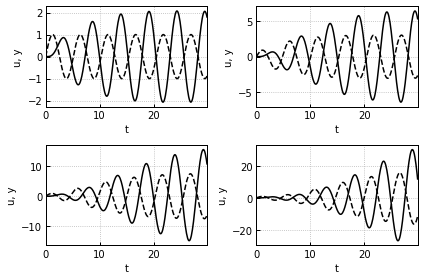

In [6]:
P = tf([0,1],[1,1,1.5,1])
# 位相が 180[deg] 遅れる周波数を取得
_, _, wpc, _ = margin(P)

t = np.arange(0, 30, 0.1)
u = np.sin(wpc*t)
y = 0 * u

fig, ax = plt.subplots(2,2,figsize=(6,4)) 
for i in range(2):
    for j in range(2):
        # 出力をネガティブフィードバックして次の時刻の入力を生成
        u = np.sin(wpc*t) - y
        y, t, x0 = lsim(P, u, t, 0)
    
        ax[i,j].plot(t,u, ls='--', label='u', color='k')
        ax[i,j].plot(t,y, label='y', color='k')
        plot_set(ax[i,j], 't', 'u, y')

fig.tight_layout()
# fig.savefig("nqp_exp2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

In [7]:
P = tf([0, 1], [1, 2, 2, 1])
print(P)
pole(P)


          1
---------------------
s^3 + 2 s^2 + 2 s + 1



array([-1. +0.j       , -0.5+0.8660254j, -0.5-0.8660254j])

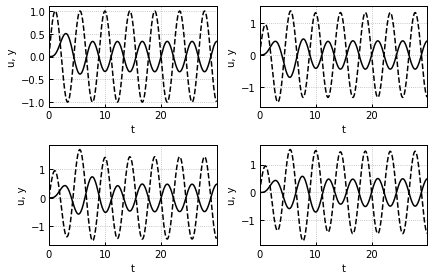

In [8]:
P = tf([0,1],[1,2,2,1])
# 位相が 180[deg] 遅れる周波数を取得
_, _, wpc, _ = margin(P)

t = np.arange(0, 30, 0.1)
u = np.sin(wpc*t)
y = 0 * u

fig, ax = plt.subplots(2,2,figsize=(6,4)) 
for i in range(2):
    for j in range(2):
        u = np.sin(wpc*t) - y
        y, t, x0 = lsim(P, u, t, 0)
    
        ax[i,j].plot(t,u, ls='--', label='u', color='k')
        ax[i,j].plot(t,y, label='y', color='k')
        plot_set(ax[i,j], 't', 'u, y')

fig.tight_layout()
# fig.savefig("nqp_exp1.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0) 

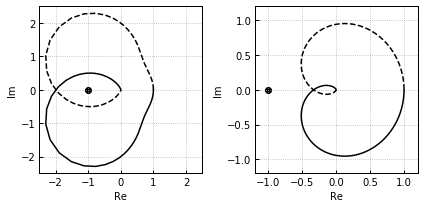

In [9]:
fig, ax = plt.subplots(1,2, figsize=(6, 3))

# 閉ループ系が不安定になる場合
P = tf([0, 1],[1, 1, 1.5, 1])
x, y, _ = nyquist(P, logspace(-3,5,1000), Plot=False)
ax[0].plot(x, y, color='k')
ax[0].plot(x, -y, ls='--', color='k')
ax[0].scatter(-1, 0, color='k')
plot_set(ax[0], 'Re', 'Im')

# 閉ループ系が安定になる場合
P = tf([0, 1],[1, 2, 2, 1])
x, y, _ = nyquist(P, logspace(-3,5,1000), Plot=False)
ax[1].plot(x, y, color='k')
ax[1].plot(x, -y, ls='--', color='k')
ax[1].scatter(-1, 0, color='k')
plot_set(ax[1], 'Re', 'Im')

ax[0].set_xlim(-2.5, 2.5)
ax[0].set_ylim(-2.5, 2.5)

ax[1].set_xlim(-1.2, 1.2)
ax[1].set_ylim(-1.2, 1.2)
fig.tight_layout()

# fig.savefig("nyquist.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## アームの角度制御（PID制御）

In [10]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]

### P制御

kP= 0.5
(GM, PM, wpc, wgc)
(inf, 21.156175957298814, nan, 12.030378476260191)
-----------------
kP= 1
(GM, PM, wpc, wgc)
(inf, 12.118321095140175, nan, 13.995414100411576)
-----------------
kP= 2
(GM, PM, wpc, wgc)
(inf, 7.419183191955369, nan, 17.217014751495988)
-----------------


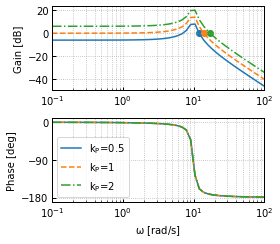

In [11]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

kp = (0.5, 1, 2)
for i in range(len(kp)):
    K = tf([0, kp[i]], [0, 1]) # P制御
    H = P * K  # 開ループ系
    gain, phase, w = bode(H, logspace(-1,2), Plot=False)
    
    # ゲイン線図と位相線図
    pltargs = {'ls':next(LS), 'label':'$k_P$='+str(kp[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
    
    # ゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
    gm, pm, Wpc, Wgc = margin(H)
    ax[0].scatter(Wgc,0)
    
    print('kP=', kp[i])
    print('(GM, PM, wpc, wgc)')
    print(margin(H))
    print('-----------------')
    
bodeplot_set(ax, 3)
    
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("loop_pcont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### PI制御

kP= 2 , kI= 0
(GM, PM, wpc, wgc)
(inf, 7.419183191955369, nan, 17.217014751495988)
-----------------
kP= 2 , kI= 5
(GM, PM, wpc, wgc)
(0.7357499999999995, -0.8650925865891281, 15.660459763365822, 17.277561531058748)
-----------------
kP= 2 , kI= 10
(GM, PM, wpc, wgc)
(0.21021428571428594, -8.761363396424741, 11.838194843085544, 17.44979293154785)
-----------------


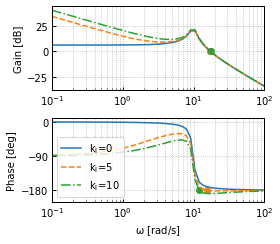

In [12]:
cmap = plt.get_cmap("tab10")

LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

kp = 2
ki = (0, 5, 10)
for i in range(3):
    K = tf([kp, ki[i]], [1, 0])  # PI制御
    H = P * K  # 開ループ系
    gain, phase, w = bode(H, logspace(-1,2), Plot=False)

    # ゲイン線図と位相線図
    pltargs = {'ls':next(LS), 'label':'$k_I$='+str(ki[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)

    # ゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
    gm, pm, Wpc, Wgc = margin(H)
    ax[0].scatter(Wgc,0)
    if Wpc:
        ax[1].scatter(Wpc,-180)

    print('kP=', kp, ', kI=', ki[i])
    print('(GM, PM, wpc, wgc)')
    print(margin(H))
    print('-----------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
fig.tight_layout()
#fig.savefig("loop_picont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

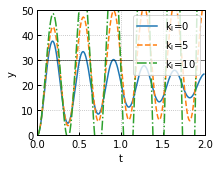

In [13]:
LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(3):
    K = tf([kp, ki[i]], [1, 0])  # PI制御
    Gyr = feedback(P*K, 1)  # 閉ループ系
    y, t = step(Gyr, np.arange(0, 2, 0.01))
    
    pltargs = {'ls':next(LS), 'label':'$k_I$='+str(ki[i])} 
    ax.plot(t, y*ref, **pltargs)

ax.axhline(ref, color="k", linewidth=0.5)
ax.set_xlim(0,2)
ax.set_ylim(0,50)
plot_set(ax, 't', 'y', 'best')

# fig.savefig("loop_picont.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### PID制御

kP= 2 , kI= 5 , kD= 0
(GM, PM, wpc, wgc)
(0.7357499999999995, -0.8650925865891281, 15.660459763365822, 17.277561531058748)
-----------------
kP= 2 , kI= 5 , kD= 0.1
(GM, PM, wpc, wgc)
(inf, 45.21166550163886, nan, 18.803688976275332)
-----------------
kP= 2 , kI= 5 , kD= 0.2
(GM, PM, wpc, wgc)
(inf, 71.27186124757236, nan, 24.730240225794656)
-----------------


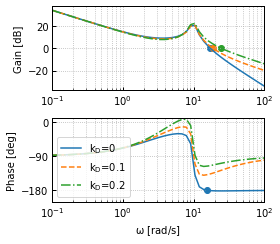

In [14]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

kp = 2
ki = 5
kd = (0, 0.1, 0.2)
for i in range(3):
    K = tf([kd[i], kp, ki], [1,0])  # PID制御
    H = P * K  # 開ループ系
    gain, phase, w = bode(H, logspace(-1,2), Plot=False)

    # ゲイン線図と位相線図
    pltargs = {'ls':next(LS), 'label':'$k_D$='+str(kd[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)

    # ゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
    gm, pm, wpc, wgc = margin(H)
    ax[0].scatter(wgc,0)
    if wpc:
        ax[1].scatter(wpc,-180)

    print('kP=', kp, ', kI=', ki, ', kD=', kd[i])
    print('(GM, PM, wpc, wgc)')
    print(margin(H))
    print('-----------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])
ax[1].legend(loc=3)

fig.tight_layout()
#fig.savefig("loop_pidcont_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

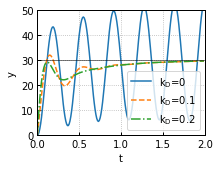

In [15]:
LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(3):
    K = tf([kd[i],kp,ki],[1,0])  # PID制御
    Gyr = feedback(P*K,1)  # 閉ループ系
    y, t = step(Gyr,np.arange(0,2,0.01))
    
    pltargs = {'ls':next(LS), 'label':'$k_D$='+str(kd[i])}
    ax.plot(t,y*ref, **pltargs)

ax.axhline(ref, color="k", linewidth=0.5)    
ax.set_xlim(0,2)
ax.set_ylim(0,50)
plot_set(ax, 't', 'y', 4)

#fig.savefig("loop_pidcont.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

開ループ系の比較

kP= 2 , kI= 5 , kD= 0.1
(GM, PM, wpc, wgc)
(inf, 45.21166550163886, nan, 18.803688976275332)
-----------------
kP= 1 , kI= 0 , kD= 0
(GM, PM, wpc, wgc)
(inf, 12.118321095140175, nan, 13.995414100411576)
-----------------


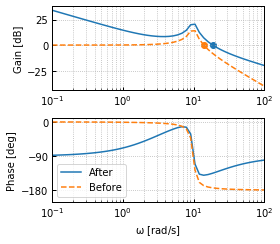

In [16]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

kp = (2, 1)
ki = (5, 0)
kd = (0.1, 0)
Label = ('After', 'Before')

for i in range(2):
    K = tf([kd[i], kp[i], ki[i]], [1,0])
    H = P * K
    gain, phase, w = bode(H, logspace(-1,2), Plot=False)

    # ゲイン線図と位相線図
    pltargs = {'ls':next(LS), 'label':Label[i]}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)

    # ゲイン余裕，位相余裕，位相交差周波数，ゲイン交差周波数
    gm, pm, Wpc, Wgc = margin(H)
    ax[0].scatter(Wgc,0)
    if Wpc:
        ax[1].scatter(Wpc,-180)

    print('kP=', kp[i], ', kI=', ki[i], ', kD=', kd[i])
    print('(GM, PM, wpc, wgc)')
    print(margin(H))
    print('-----------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
#fig.savefig("loop_pidcont_bode_comp.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 閉ループ系の比較

0 states have been removed from the model
定常偏差 = -1.9984014443252818e-14
------------------
1 states have been removed from the model
定常偏差 = 14.856133266027259
------------------


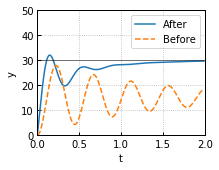

In [17]:
LS = linestyle_generator()
fig, ax = plt.subplots(figsize=(3, 2.3))

for i in range(2):
    K = tf( [kd[i], kp[i], ki[i]], [1, 0])
    Gyr = feedback(P*K, 1)
    Gyr = minreal(Gyr)
    y, t = step(Gyr,np.arange(0,2,0.01))
    
    pltargs = {'ls':next(LS), 'label':Label[i]}
    ax.plot(t, y*ref, **pltargs)
    
    e_std = ref * (1 - Gyr.dcgain())
    print('定常偏差 =', e_std)    
    print('------------------')

ax.axhline(ref, color="k", linewidth=0.5)    
ax.set_xlim(0,2)
ax.set_ylim(0,50)
plot_set(ax, 't', 'y', 1)

#fig.savefig("loop_pidcont_comp.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

直流ゲイン = 5.785964799319721e-15
------------------
直流ゲイン = -5.937689510770942
------------------


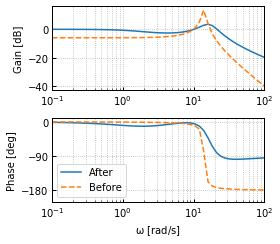

In [18]:
LS = linestyle_generator()
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

for i in range(2):
    K = tf( [kd[i], kp[i], ki[i]], [1,0])
    Gyr = feedback(P*K, 1)
    Gyr = Gyr.minreal()
    gain, phase, w = bode(Gyr, logspace(-1,2), Plot=False)
    
    pltargs = {'ls':next(LS), 'label':Label[i]}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
    
    print('直流ゲイン =', 20*np.log10(Gyr.dcgain()))    
    print('------------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
#fig.savefig("loop_pidcont_fbbode_comp.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## 位相遅れ・進み補償

### 位相遅れ

omegam= 3.162277660168379
phim= -54.903198772415415


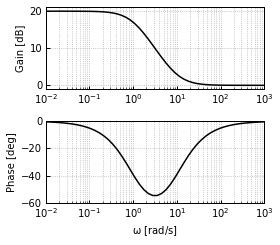

In [19]:
alpha = 10
T1 = 0.1
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(K1, logspace(-2,3), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')

bodeplot_set(ax)
ax[1].set_ylim(-60, 0)

omegam = 1/T1/np.sqrt(alpha)
phim = np.arcsin( (1-alpha)/(1+alpha) ) * 180/np.pi
print('omegam=', omegam)
print('phim=', phim)

fig.tight_layout()
# fig.savefig("lag_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

omegam= 0.03162277660168379
phim= -89.63763088074153


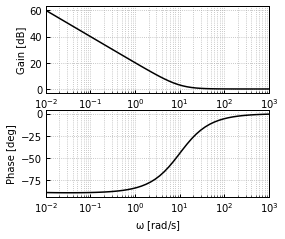

In [20]:
alpha = 100000
T1 = 0.1
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(K1, logspace(-2,3), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')

bodeplot_set(ax)
omegam = 1/T1/np.sqrt(alpha)
phim = np.arcsin( (1-alpha)/(1+alpha) ) * 180/np.pi
print('omegam=', omegam)
print('phim=', phim)

### 位相進み

omegam= 3.162277660168379
phim= 54.9031987724154


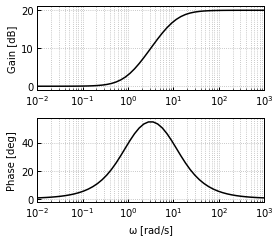

In [21]:
beta = 0.1
T2 = 1
K2 = tf([T2, 1],[beta*T2, 1])

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(K2, logspace(-2,3), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')

bodeplot_set(ax)

omegam = 1/T2/np.sqrt(beta)
phim = np.arcsin( (1-beta)/(1+beta) ) * 180/np.pi
print('omegam=', omegam)
print('phim=', phim)

fig.tight_layout()
# fig.savefig("lead_bode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

omegam= 1000.0
phim= 89.88540847917132


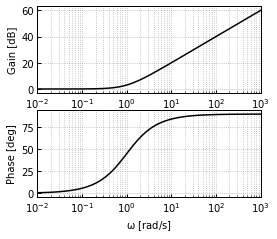

In [22]:
beta = 0.000001
T2 = 1
K2 = tf([T2, 1],[beta*T2, 1])

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(K2, logspace(-2,3), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')

bodeplot_set(ax)

omegam = 1/T2/np.sqrt(beta)
phim = np.arcsin( (1-beta)/(1+beta) ) * 180/np.pi
print('omegam=', omegam)
print('phim=', phim)

## アームの角度制御（位相遅れ・進み補償）

In [23]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
M  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数
J  = 1.0e-2              # 慣性モーメント

P = tf( [0,1], [J, mu, M*g*l] )

ref = 30 # 目標角度 [deg]

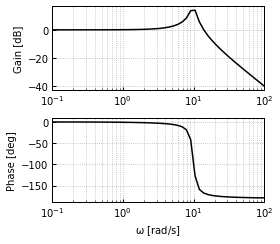

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
    
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')

bodeplot_set(ax)

fig.tight_layout()
# fig.savefig("loop_leadlag_plant.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

制御対象のボード線図．
低周波ゲインが０[dB]なので，このままフィードバック系を構築しても定常偏差が残る．

### 位相遅れ補償の設計

** 定常偏差を小さくするために，位相遅れ補償から設計する **

低周波ゲインを上げるために，$\alpha=20$とする．そして，ゲインを上げる周波数は，$T_1$で決めるが，最終的なゲイン交差周波数（ゲイン交差周波数の設計値）の１０分の１程度を$1/T_1$にするために，$T_1=0.25$とする（$1/T_1=40/10=4$）．

K1= 
5 s + 20
--------
5 s + 1

-----------------------
phase at 40rad/s = 176.8635987273622


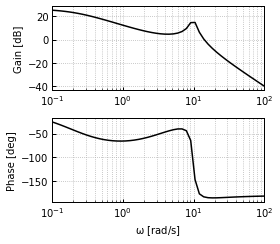

In [25]:
alpha = 20
T1 = 0.25
#T1 = 1/6
K1 = tf([alpha*T1, alpha], [alpha*T1, 1])
print('K1=', K1)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H1 = P*K1
gain, phase, w = bode(H1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
bodeplot_set(ax)
fig.tight_layout()

# fig.savefig("loop_leadlag_L1.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

[[[mag]]], [[[phase]]], omega = freqresp(H1, [40])
#magH1at40 = mag
phaseH1at40 = phase * (180/np.pi)
print('-----------------------')
#print('gain at 40rad/s =', 20*np.log10(magH1at40))
print('phase at 40rad/s =', phaseH1at40)

最終的にゲイン補償によって，ゲイン交差周波数を設計値の40[rad/s]まで上げるが，あげてしまうと，位相余裕が60[dB]を下回る．実際， 40[rad/s]における位相は -176[deg]なので，位相余裕は 4[deg]程度になってしまう．したがって，40[rad/s]での位相を -120[deg] まであげておく．

### 位相進み補償の設計

** 位相進み補償の設計 ** 

40[rad/s]において位相を進ませる量は　60 - (180-176) = 56[deg]程度とする．

K2= 
 0.1047 s + 1
--------------
0.005971 s + 1

-----------------------
gain at 40rad/s = -11.058061395752677
phase at 40rad/s = -119.99999999999997


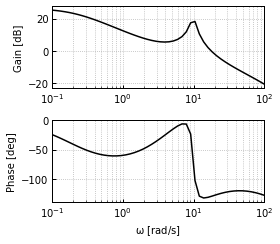

In [26]:
phim = (60- (180 + phaseH1at40 ) ) * np.pi/180
beta = (1-np.sin(phim))/(1+np.sin(phim))
T2 = 1/40/np.sqrt(beta)
K2 = tf([T2, 1],[beta*T2, 1])
print('K2=', K2)

fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 
H2 = P*K1*K2
gain, phase, w = bode(H2, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), color='k')
ax[1].semilogx(w, phase*180/np.pi, color='k')
bodeplot_set(ax)

fig.tight_layout()
# fig.savefig("loop_leadlag_L2.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

[[[mag]]], [[[phase]]], omega = freqresp(H2, [40])
magH2at40 = mag
phaseH2at40 = phase * (180/np.pi)
print('-----------------------')
print('gain at 40rad/s =', 20*np.log10(magH2at40))
print('phase at 40rad/s =', phaseH2at40)

In [27]:
magH2at40

0.2799606094167923

位相進み補償により，40[rad/s]での位相が -120[deg]となっている．
あとは，ゲイン補償により，40[rad/s]のゲインを 0[dB] にすればよい．

### ゲイン補償の設計

** ゲイン補償の設計 **

40[rad/s] におけるゲインが -11.06[dB] 程度なので， 11.06[dB]分上に移動させる．
そのために，$k = 1/magL2at40$ をゲイン補償とする．
これにより，40[rad/s]がゲイン交差周波数になり，位相余裕もPM=60[deg]となる．

k= 3.571931073029087
-----------------
(GM, PM, wpc, wgc)
(inf, 60.00000000000003, nan, 40.000000000000014)


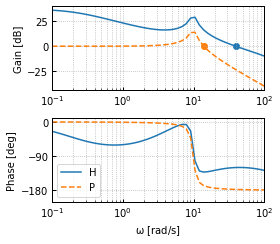

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

k = 1/magH2at40
print('k=', k)

H = P*k*K1*K2
gain, phase, w = bode(H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='H')
ax[1].semilogx(w, phase*180/np.pi, label='H')

gm, pm, wpc, wgc = margin(H)
ax[0].scatter(wgc,0)

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), ls='--', label='P')
ax[1].semilogx(w, phase*180/np.pi, ls='--', label='P')

gm, pm, wcp, wgc = margin(P)
ax[0].scatter(wgc,0)

bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("loop_leadlag_L3.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

print('-----------------')
print('(GM, PM, wpc, wgc)')
print(margin(H))

### 閉ループ系の応答

error= 0.013546052578222278
------------------
error= 0.49520444220090865
------------------


(0, 50)

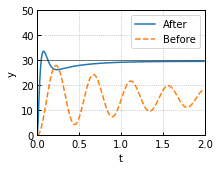

In [29]:
fig, ax = plt.subplots(figsize=(3, 2.3))

Gyr_H = feedback(H, 1)
y, t = step(Gyr_H, np.arange(0,2,0.01))

ax.plot(t,y*ref, label='After')

e_std = 1 - dcgain(Gyr_H)
print('error=', e_std)    
print('------------------')

Gyr_P = feedback(P, 1)
y, t = step(Gyr_P, np.arange(0,2,0.01))
pltargs = {'ls': '--', 'label': 'Before'}
ax.plot(t, y*ref, **pltargs)
    
e_std = 1 - dcgain(Gyr_P)
print('error=', e_std)    
print('------------------')

ax.axhline(ref, color="k", linewidth=0.5)  
plot_set(ax, 't', 'y', 'best')
ax.set_xlim(0,2)
ax.set_ylim(0,50)

# fig.savefig("loop_leadlag_step.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

直流ゲイン = -0.11846369931437545
------------------
直流ゲイン = -5.937689510770942
------------------


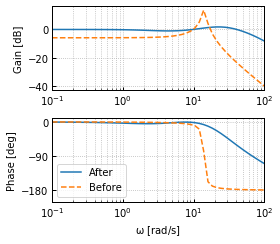

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(Gyr_H, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), label='After')
ax[1].semilogx(w, phase*180/np.pi, label='After')

print('直流ゲイン =', 20*np.log10(Gyr_H.dcgain()))    
print('------------------')


gain, phase, w = bode(Gyr_P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
ax[1].semilogx(w, phase*180/np.pi, **pltargs)

print('直流ゲイン =', 20*np.log10(Gyr_P.dcgain()))    
print('------------------')
    
bodeplot_set(ax, 3)

ax[1].set_ylim(-210,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()
# fig.savefig("loop_leadlag_fbbode.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)